# Image compression

The input image is $512 \times 512$ pixel size each of which is described by a $24$-bit color ($8$ bit per RGB channel). If you store the image pixel-wise it will take $512 \times 512 \times 3 = 786432$ bytes.

If we reduce the number of colors, this will reduce the number of bits stored significantly. In order to ensure the quality of the compressed images, we have to figure out what colors to keep the maximum information. Here is where k-means steps in. We will find 16 groups of similar colors and change every 24-bit color to the centroid of the corresponding group.

In [1]:
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

## Initialization

Loading an image for compression.

In [3]:
input_image_file = "mandrill-large.png"

Number of colors for the output image (i.e. number of clusters).

In [4]:
num_colors = num_clusters = 16

Random seed.


In [5]:
random_seed = 42

## Loading the data

Loading the data as an array of pixels.

In [6]:
input_img = img.imread(input_image_file)

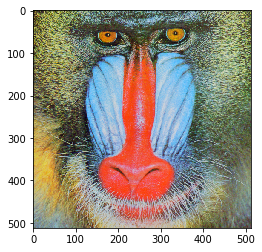

In [7]:
plt.imshow(input_img)
plt.show()

Initializing $m \times n$ training matrix.

In [8]:
color_depth = input_img.shape[-1]

In [9]:
X = input_img.reshape(-1, color_depth)

In [10]:
X.shape

(262144, 3)

## K-Means clustering

In [11]:
np.random.seed(random_seed)

Initialize centroids as colors of random pixels of the picture.

In [12]:

centroids = np.asarray([X[i] for i in np.random.choice(range(0, len(X)), num_clusters, replace=False)]) 
centroids.shape

(16, 3)

Initizlizing a variable for storing closest centroids for every pixel.

In [13]:
closest_centroids = np.zeros(len(X))

Find the closest centroid for every data point.

In [14]:
def get_closest_centroids(X, centroids):
    res = [np.argmin([np.sum(np.power(x - c, 2)) for c in centroids]) for x in X]
    return np.asarray(res)

Move centroids to the mean of all assigned points.

In [15]:
def move_centroids(X, closest_centroids, num_clusters):
    res = np.zeros((num_clusters, X.shape[-1]))
    for i in range(num_clusters):
        assigned_points = X[closest_centroids == i] 
        res[i] = np.mean(assigned_points, axis=0)
    return res

Compute k-means cost function.

In [16]:
def kmeans_objective(X, centroids, closest_centroids):
    cost_sum = 0
    for i in range(len(centroids)):
        assigned_points = X[closest_centroids == i]
        cost_sum += np.sum(np.power(assigned_points - centroids[i], 2))
    
    return cost_sum

Implement k-means iteration until convergence.

In [17]:
objective_history = []
convergence = False
iteration = 0
while not convergence: 
    
    closest_centroids = get_closest_centroids(X, centroids)
    centroids = move_centroids(X, closest_centroids, num_clusters)  
    objective = kmeans_objective(X, centroids, closest_centroids)
    objective_history.append(objective)
    
    iteration += 1
    convergence = len(objective_history) > 2 and (objective_history[-2]/objective_history[-1] < 1.01 or iteration> 50)
    
    print("Iteration: {0:2d}    Objective: {1:.3f}".format(iteration, objective))

Iteration:  1    Objective: 3945.041
Iteration:  2    Objective: 3177.225
Iteration:  3    Objective: 2801.601
Iteration:  4    Objective: 2694.786
Iteration:  5    Objective: 2651.845
Iteration:  6    Objective: 2627.193


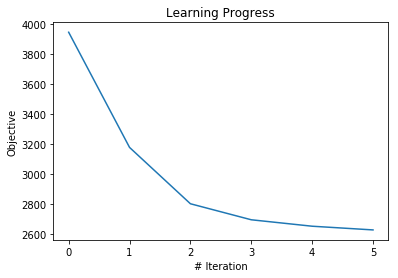

In [18]:
ax = plt.plot(objective_history)[0].axes

ax.set(xlabel="# Iteration")
ax.set(ylabel="Objective")
ax.set(title="Learning Progress")

plt.show()

## Compression results

Represent each point as a closest centroid.

In [19]:
output_img = centroids[closest_centroids].reshape(input_img.shape)

Compare original and compressed images.

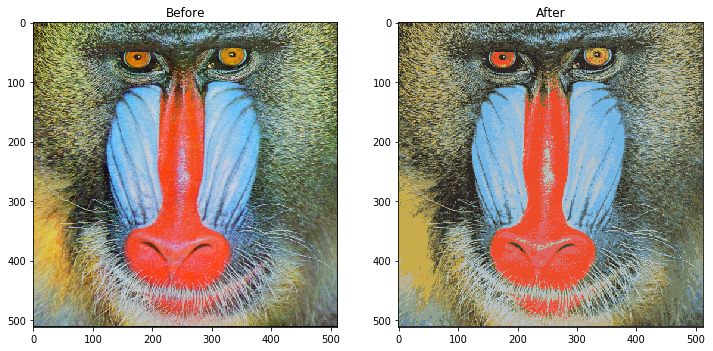

In [20]:
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(12, 12))

ax_before.imshow(input_img)
ax_after.imshow(output_img)

ax_before.set(title="Before")
ax_after.set(title="After")

plt.show()